In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from KANConv import KAN_Convolutional_Layer

# Global variables
global device, print_freq
print_freq = 300
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)

WORKING_PATH = 'KAN_propfree_Result/'
os.makedirs(WORKING_PATH, exist_ok=True)

cuda


In [2]:
# Dataset class
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, inp, out):
        self.inp = inp
        self.out = out

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self, index):
        return self.inp[index], self.out[index]

# AverageMeter class
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## KAN CONV Only

In [3]:
class RVEKAN_propfree(nn.Module):
    def __init__(self):
        super(RVEKAN_propfree, self).__init__()
        self.conv1 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),device=device)
        self.conv2 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),device=device)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 3)
        self.relu = nn.LeakyReLU()
        self.softplus = nn.Softplus()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.7)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softplus(x)
        return x

In [4]:
def train_NN(model, net_info, train_loader, test_loader):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    test_losses = []
    train_losses = []
    best_model = copy.deepcopy(model)
    best_loss = 1e10
    es = 0

    for epoch in range(net_info['num_epochs']):
        model.train()
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        start = time.time()

        for i, (input_, output) in enumerate(train_loader):
            input_, output = input_.to(device), output.to(device)
            data_time.update(time.time() - start)
            optimizer.zero_grad()
            outputs = model(input_)
            loss = criterion(outputs, output)
            loss.backward()
            optimizer.step()
            
            losses.update(loss.item(), input_.size(0))
            batch_time.update(time.time() - start)
            start = time.time()
            
            if i % print_freq == 0:
                print(f'Epoch [{epoch+1}/{net_info["num_epochs"]}], '
                      f'Batch [{i}/{len(train_loader)}], '
                      f'Loss: {loss.item():.6f}, '
                      f'Avg Batch Time: {batch_time.avg:.3f}, '
                      f'Avg Data Time: {data_time.avg:.3f}')

        train_losses.append(losses.avg)
        model.eval()
        val_losses = AverageMeter()

        with torch.no_grad():
            for i, (input_, output) in enumerate(test_loader):
                input_, output = input_.to(device), output.to(device)
                outputs = model(input_)
                loss = criterion(outputs, output)
                val_losses.update(loss.item(), input_.size(0))

        test_losses.append(val_losses.avg)
        if val_losses.avg < best_loss:
            best_loss = val_losses.avg
            best_model = copy.deepcopy(model)
            es = 0
        else:
            es += 1
            if es > net_info['early_stop']:
                print('Early stopping!')
                break
        scheduler.step()

    model.load_state_dict(best_model.state_dict())
    torch.save(model.state_dict(), WORKING_PATH + 'best_model_' + str(net_info['model_version']) + '_augmented_' + str(net_info['augment']) + '.pth.tar')
    
    np.array(test_losses).tofile(WORKING_PATH + 'val_loss_KANpropfree' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")
    np.array(train_losses).tofile(WORKING_PATH + 'train_loss_KANpropfree' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('MSE')
    ax[0].title.set_text('Training loss')
    ax[0].set_yscale('log')

    ax[1].plot(test_losses)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('MSE')
    ax[1].title.set_text('Test loss')
    ax[1].set_yscale('log')
    plt.show()
    return model

In [5]:
def main_program(inp, out, trainer_info, model_name):
    num_sample = trainer_info['train_size']
    
    inp_train = inp[0:num_sample, :, :, :]
    out_train = out[0:num_sample]
    training_set = MyDataset(inp_train,out_train)

    inp_test = inp[num_sample:inp.shape[0], :, :, :]
    out_test = out[num_sample:inp.shape[0]]
    test_set = MyDataset(inp_test, out_test)

    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = RVEKAN_propfree().to(device)
    if torch.cuda.is_available():
        model = model.cuda()
    print(model_name)
    print(model)

    model = train_NN(model, trainer_info, train_loader, test_loader)
    torch.save(model.state_dict(), WORKING_PATH + model_name)

    return model

(4000, 3)
(4000, 128, 128)
model name: model_3200train_150ep_KAN_propfree
cuda
model_3200train_150ep_KAN_propfree
RVEKAN_propfree(
  (conv1): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (conv2): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (fc1): KANLinear(
    (base_activation): SiLU()
  )
  (fc2): KANLinear(
    (base_activation): SiLU()
  )
  (relu): LeakyReLU(negative_slope=0.01)
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
)
Epoch [1/150], Batch [0/13], Loss: 0.377494, Avg Batch Time: 1.065, Avg Data Time: 0.046
Epoch [2/150], Batch [0/13], Loss: 0.288306, Avg Batch Time: 0.850, Avg Data Time: 0.009


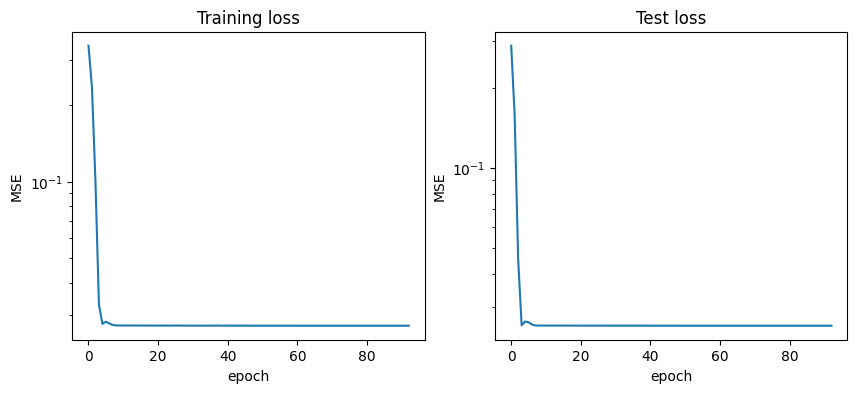

In [25]:
if __name__ == "__main__":
    ## In RVEKAN_propfree we neglect the existence of material properties
    ## This first approach is simply not to use material properties as input, so we only get
    ## 128*128 figure input and use a KANconv NN to train and perdict the stiffness as output 
    # load data
    stiffness = np.load(file='data/cnn_homogenized_stiffness_part2.npy')
    rve_masks = np.load(file='data/cnn_rve_masks_part2_rve.npy')

    # normalize stiffness (normalize to [0,1])
    stiffness_scaler = MinMaxScaler()
    stiffness = stiffness_scaler.fit_transform(stiffness)
    joblib.dump(stiffness_scaler, WORKING_PATH + 'stiffness_scaler.pkl')

    print(stiffness.shape)
    print(rve_masks.shape)

    rve_tensor = torch.from_numpy(rve_masks).float()
    rve_tensor = rve_tensor.unsqueeze(1)
    stiffness_tensor = torch.from_numpy(stiffness).float()
    size = int(stiffness_tensor.shape[0]*0.8)
    is_augment = False
    trainer_info = {
        'num_epochs': 150,
        'train_size': size,
        'train_batch': 256,
        'test_batch': 512,
        'lr0': 5e-4,
        'when_decay': 50,
        'lr_decay': 0.1,
        'early_stop': 10,
        'augment': is_augment,
        'model_version': '1'
    }

    note = 'KAN_propfree'

    model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(trainer_info['num_epochs']) + 'ep_' + note

    print('model name: ' + model_name)
    print(device)

    KAN_propfree_model = main_program(rve_tensor, stiffness_tensor, trainer_info, model_name)

## KAN CONV+KAN Linear (still without prop)

In [21]:
from KANLinear import KANLinear

In [22]:
class RVEKAN_propfree(nn.Module):
    def __init__(self):
        super(RVEKAN_propfree, self).__init__()
        self.conv1 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), device=device)
        self.conv2 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), device=device)
        self.fc1 = KANLinear(256, 256)
        self.fc2 = KANLinear(256, 3)
        self.relu = nn.LeakyReLU()
        self.softplus = nn.Softplus()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.7)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softplus(x)
        return x

In [23]:
def train_NN(model, net_info, train_loader, test_loader):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    test_losses = []
    train_losses = []
    best_model = copy.deepcopy(model)
    best_loss = 1e10
    es = 0

    for epoch in range(net_info['num_epochs']):
        model.train()
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        start = time.time()

        for i, (input_, output) in enumerate(train_loader):
            input_, output = input_.to(device), output.to(device)
            data_time.update(time.time() - start)
            optimizer.zero_grad()
            outputs = model(input_)
            loss = criterion(outputs, output)
            loss.backward()
            optimizer.step()
            
            losses.update(loss.item(), input_.size(0))
            batch_time.update(time.time() - start)
            start = time.time()
            
            if i % print_freq == 0:
                print(f'Epoch [{epoch+1}/{net_info["num_epochs"]}], '
                      f'Batch [{i}/{len(train_loader)}], '
                      f'Loss: {loss.item():.6f}, '
                      f'Avg Batch Time: {batch_time.avg:.3f}, '
                      f'Avg Data Time: {data_time.avg:.3f}')

        train_losses.append(losses.avg)
        model.eval()
        val_losses = AverageMeter()

        with torch.no_grad():
            for i, (input_, output) in enumerate(test_loader):
                input_, output = input_.to(device), output.to(device)
                outputs = model(input_)
                loss = criterion(outputs, output)
                val_losses.update(loss.item(), input_.size(0))

        test_losses.append(val_losses.avg)
        if val_losses.avg < best_loss:
            best_loss = val_losses.avg
            best_model = copy.deepcopy(model)
            es = 0
        else:
            es += 1
            if es > net_info['early_stop']:
                print('Early stopping!')
                break
        scheduler.step()

    model.load_state_dict(best_model.state_dict())
    torch.save(model.state_dict(), WORKING_PATH + 'best_model_' + str(net_info['model_version']) + '_augmented_' + str(net_info['augment']) + '.pth.tar')
    
    np.array(test_losses).tofile(WORKING_PATH + 'val_loss_KKANpropfree' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")
    np.array(train_losses).tofile(WORKING_PATH + 'train_loss_KKANpropfree' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('MSE')
    ax[0].title.set_text('Training loss')
    ax[0].set_yscale('log')

    ax[1].plot(test_losses)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('MSE')
    ax[1].title.set_text('Test loss')
    ax[1].set_yscale('log')
    plt.show()
    return model

(4000, 3)
(4000, 128, 128)
model name: model_3200train_150ep_KAN_propfree
cuda
model_3200train_150ep_KAN_propfree
RVEKAN_propfree(
  (conv1): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (conv2): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (fc1): KANLinear(
    (base_activation): SiLU()
  )
  (fc2): KANLinear(
    (base_activation): SiLU()
  )
  (relu): LeakyReLU(negative_slope=0.01)
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
)
Epoch [1/150], Batch [0/13], Loss: 0.370502, Avg Batch Time: 1.090, Avg Data Time: 0.022
Epoch [2/150], Batch [0/13], Loss: 0.287004, Avg Batch Time: 0.841, Avg Data Time: 0.004


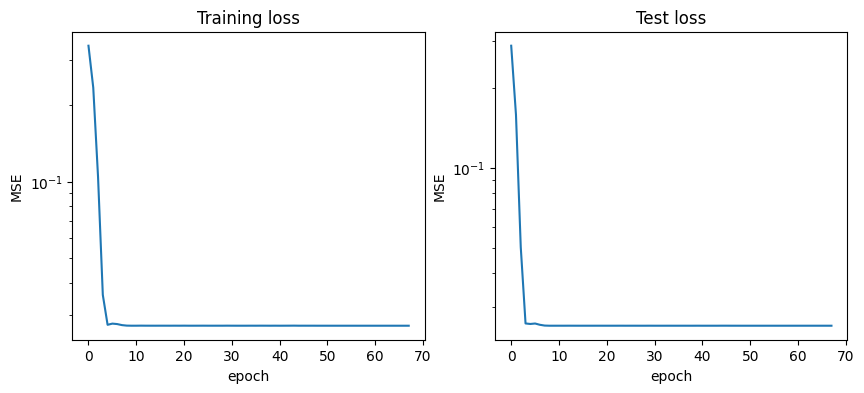

In [26]:
if __name__ == "__main__":
    ## In RVEKAN_propfree we neglect the existence of material properties
    ## This first approach is simply not to use material properties as input, so we only get
    ## 128*128 figure input and use a KANconv NN to train and perdict the stiffness as output 
    # load data
    stiffness = np.load(file='data/cnn_homogenized_stiffness_part2.npy')
    rve_masks = np.load(file='data/cnn_rve_masks_part2_rve.npy')

    # normalize stiffness (normalize to [0,1])
    stiffness_scaler = MinMaxScaler()
    stiffness = stiffness_scaler.fit_transform(stiffness)
    joblib.dump(stiffness_scaler, WORKING_PATH + 'stiffness_scaler.pkl')

    print(stiffness.shape)
    print(rve_masks.shape)

    rve_tensor = torch.from_numpy(rve_masks).float()
    rve_tensor = rve_tensor.unsqueeze(1)
    stiffness_tensor = torch.from_numpy(stiffness).float()
    size = int(stiffness_tensor.shape[0]*0.8)
    is_augment = False
    trainer_info = {
        'num_epochs': 150,
        'train_size': size,
        'train_batch': 256,
        'test_batch': 512,
        'lr0': 5e-4,
        'when_decay': 50,
        'lr_decay': 0.1,
        'early_stop': 10,
        'augment': is_augment,
        'model_version': '1'
    }

    note = 'KAN_propfree'

    model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(trainer_info['num_epochs']) + 'ep_' + note

    print('model name: ' + model_name)
    print(device)

    KKAN_propfree_model = main_program(rve_tensor, stiffness_tensor, trainer_info, model_name)

## Comparison for with/without mat_prop

In [29]:
import time
import copy
import pandas as pd
import glob

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

KAN_propfree_num_params = count_parameters(KAN_propfree_model)
KKAN_propfree_num_params = count_parameters(KKAN_propfree_model)

print("The number of parameters in KAN_propfree:", KAN_propfree_num_params)
print("The number of parameters in KKAN_propfree:", KKAN_propfree_num_params)

train_loss_KANfree = pd.read_csv('KAN_propfree_Result/train_loss_augmented_False.csv', header=None)
val_loss_KANfree = pd.read_csv('KAN_propfree_Result/val_loss_augmented_False.csv', header=None)

train_loss_KANavg = pd.read_csv('KAN_avgprop/train_loss_KANavgprop_augmented_False.csv', header=None)
val_loss_KANavg = pd.read_csv('KAN_avgprop/val_loss_KANavgprop_augmented_False.csv', header=None)

train_loss_KKANfree = pd.read_csv('KAN_propfree_Result/train_loss_KKANpropfree_augmented_False.csv', header=None)
val_loss_KKANfree = pd.read_csv('KAN_propfree_Result/val_loss_KKANpropfree_augmented_False.csv', header=None)

train_loss_KKANavg = pd.read_csv('KAN_avgprop/train_loss_KKANavgprop_augmented_False.csv', header=None)
val_loss_KKANavg = pd.read_csv('KAN_avgprop/val_loss_KKANavgprop_augmented_False.csv', header=None)

train_loss_KAN = pd.read_csv('KANResult/train_loss_augmented_False.csv', header=None)
val_loss_KAN = pd.read_csv('KANResult/val_loss_augmented_False.csv', header=None)

train_loss_KKAN = pd.read_csv('KKANResult/train_loss_augmented_False.csv', header=None)
val_loss_KKAN = pd.read_csv('KKANResult/val_loss_augmented_False.csv', header=None)

train_loss_KANfree.index = range(1, len(train_loss_KANfree) + 1)
val_loss_KANfree.index = range(1, len(val_loss_KANfree) + 1)
train_loss_KANavg.index = range(1, len(train_loss_KANavg) + 1)
val_loss_KANavg.index = range(1, len(val_loss_KANavg) + 1)

train_loss_KKANfree.index = range(1, len(train_loss_KKANfree) + 1)
val_loss_KKANfree.index = range(1, len(val_loss_KKANfree) + 1)
train_loss_KKANavg.index = range(1, len(train_loss_KKANavg) + 1)
val_loss_KKANavg.index = range(1, len(val_loss_KKANavg) + 1)

train_loss_KAN.index = range(1, len(train_loss_KAN) + 1)
val_loss_KAN.index = range(1, len(val_loss_KAN) + 1)
train_loss_KKAN.index = range(1, len(train_loss_KKAN) + 1)
val_loss_KKAN.index = range(1, len(val_loss_KKAN) + 1)

train_loss_KANfree = train_loss_KANfree.T
val_loss_KANfree = val_loss_KANfree.T
train_loss_KANavg = train_loss_KANavg.T
val_loss_KANavg = val_loss_KANavg.T

train_loss_KKANfree = train_loss_KKANfree.T
val_loss_KKANfree = val_loss_KKANfree.T
train_loss_KKANavg = train_loss_KKANavg.T
val_loss_KKANavg = val_loss_KKANavg.T

train_loss_KAN = train_loss_KAN.T
val_loss_KAN = val_loss_KAN.T
train_loss_KKAN = train_loss_KKAN.T
val_loss_KKAN = val_loss_KKAN.T

train_loss_KANfree.columns = ['loss']
val_loss_KANfree.columns = ['loss']
train_loss_KANavg.columns = ['loss']
val_loss_KANavg.columns = ['loss']

train_loss_KKANfree.columns = ['loss']
val_loss_KKANfree.columns = ['loss']
train_loss_KKANavg.columns = ['loss']
val_loss_KKANavg.columns = ['loss']

train_loss_KAN.columns = ['loss']
val_loss_KAN.columns = ['loss']
train_loss_KKAN.columns = ['loss']
val_loss_KKAN.columns = ['loss']

KANfree_Acc= 1-val_loss_KANfree.min().min()
KANavg_Acc= 1-val_loss_KANavg.min().min()
KKANfree_Acc= 1-val_loss_KKANfree.min().min()
KKANavg_Acc= 1-val_loss_KKANavg.min().min()
KAN_Acc= 1-val_loss_KAN.min().min()
KKAN_Acc= 1-val_loss_KKAN.min().min()

print('kanfree acc=',KANfree_Acc)
print('kanavg acc=',KANavg_Acc)
print('kkanfree acc=',KKANfree_Acc)
print('kkanfree acc=',KKANavg_Acc)
print('kan acc=',KAN_Acc)
print('kkan acc=',KKAN_Acc)

The number of parameters in KAN_propfree: 663220
The number of parameters in KKAN_propfree: 663220
kanfree acc= 0.97455
kanavg acc= 0.97448
kkanfree acc= 0.97458
kkanfree acc= 0.97456
kan acc= 0.99804
kkan acc= 0.99947


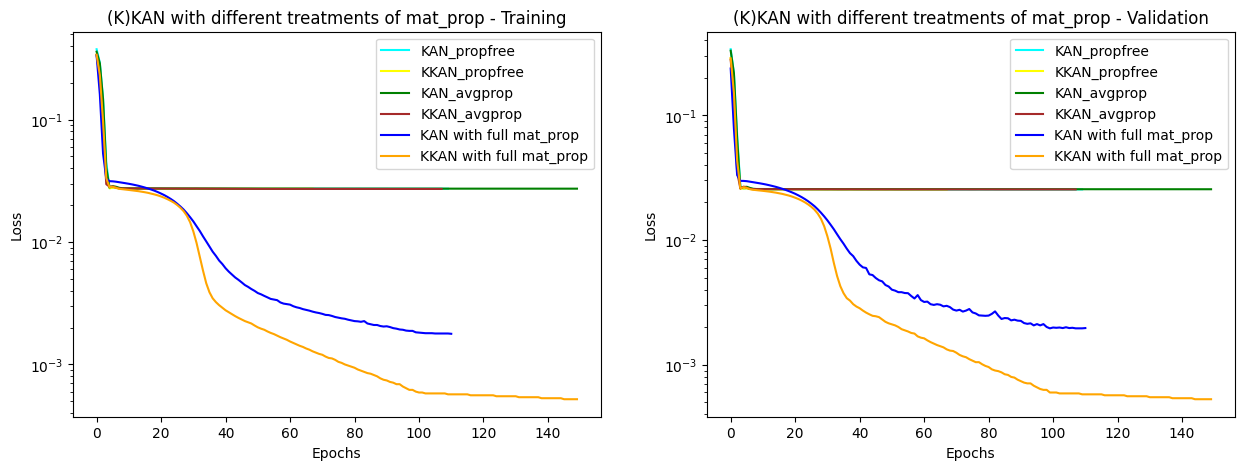

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_loss_KANfree.index, train_loss_KANfree['loss'], label='KAN_propfree', color='cyan')
ax1.plot(train_loss_KKANfree.index, train_loss_KKANfree['loss'], label='KKAN_propfree', color='yellow')
ax1.plot(train_loss_KANavg.index, train_loss_KANavg['loss'], label='KAN_avgprop', color='green')
ax1.plot(train_loss_KKANavg.index, train_loss_KKANavg['loss'], label='KKAN_avgprop', color='brown')
ax1.plot(train_loss_KAN.index, train_loss_KAN['loss'], label='KAN with full mat_prop', color='blue')
ax1.plot(train_loss_KKAN.index, train_loss_KKAN['loss'], label='KKAN with full mat_prop', color='orange')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_yscale('log')
ax1.set_title('(K)KAN with different treatments of mat_prop - Training')
ax1.legend()

ax2.plot(val_loss_KANfree.index, val_loss_KANfree['loss'], label='KAN_propfree', color='cyan')
ax2.plot(val_loss_KKANfree.index, val_loss_KKANfree['loss'], label='KKAN_propfree', color='yellow')
ax2.plot(val_loss_KANavg.index, val_loss_KANavg['loss'], label='KAN_avgprop', color='green')
ax2.plot(val_loss_KKANavg.index, val_loss_KKANavg['loss'], label='KKAN_avgprop', color='brown')
ax2.plot(val_loss_KAN.index, val_loss_KAN['loss'], label='KAN with full mat_prop', color='blue')
ax2.plot(val_loss_KKAN.index, val_loss_KKAN['loss'], label='KKAN with full mat_prop', color='orange')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.set_title('(K)KAN with different treatments of mat_prop - Validation')
ax2.legend()

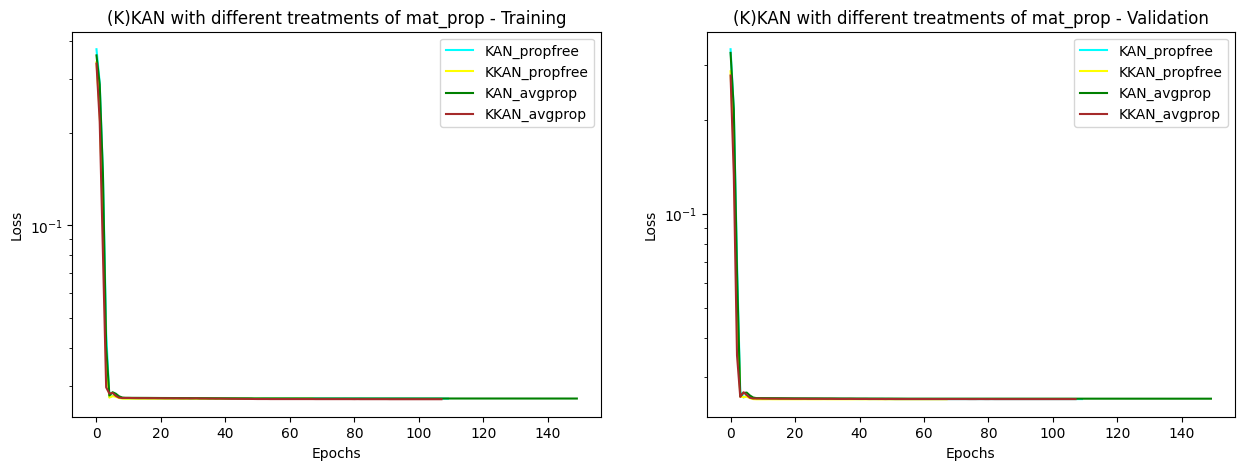

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_loss_KANfree.index, train_loss_KANfree['loss'], label='KAN_propfree', color='cyan')
ax1.plot(train_loss_KKANfree.index, train_loss_KKANfree['loss'], label='KKAN_propfree', color='yellow')
ax1.plot(train_loss_KANavg.index, train_loss_KANavg['loss'], label='KAN_avgprop', color='green')
ax1.plot(train_loss_KKANavg.index, train_loss_KKANavg['loss'], label='KKAN_avgprop', color='brown')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_yscale('log')
ax1.set_title('(K)KAN with different treatments of mat_prop - Training')
ax1.legend()

ax2.plot(val_loss_KANfree.index, val_loss_KANfree['loss'], label='KAN_propfree', color='cyan')
ax2.plot(val_loss_KKANfree.index, val_loss_KKANfree['loss'], label='KKAN_propfree', color='yellow')
ax2.plot(val_loss_KANavg.index, val_loss_KANavg['loss'], label='KAN_avgprop', color='green')
ax2.plot(val_loss_KKANavg.index, val_loss_KKANavg['loss'], label='KKAN_avgprop', color='brown')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.set_title('(K)KAN with different treatments of mat_prop - Validation')
ax2.legend()

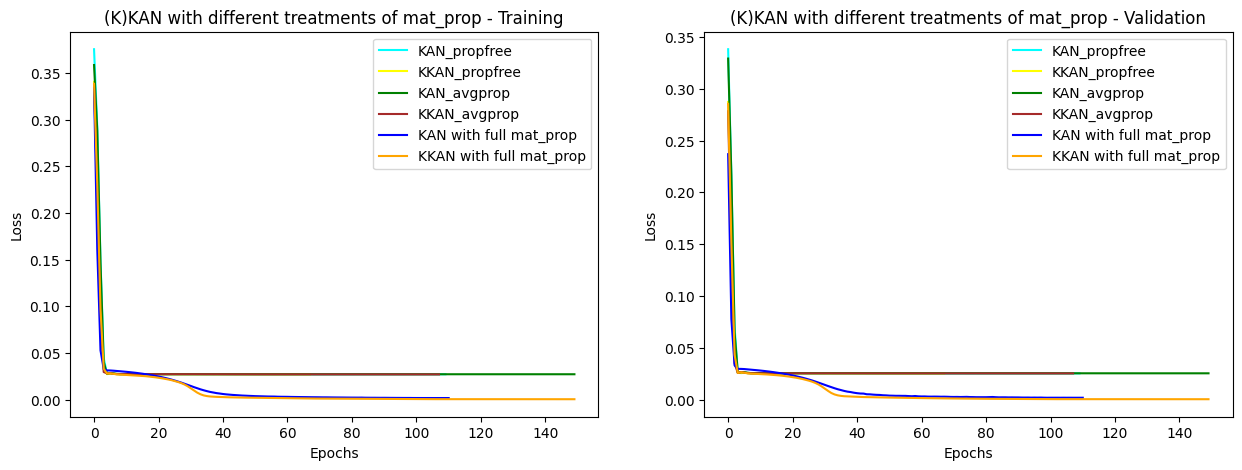

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_loss_KANfree.index, train_loss_KANfree['loss'], label='KAN_propfree', color='cyan')
ax1.plot(train_loss_KKANfree.index, train_loss_KKANfree['loss'], label='KKAN_propfree', color='yellow')
ax1.plot(train_loss_KANavg.index, train_loss_KANavg['loss'], label='KAN_avgprop', color='green')
ax1.plot(train_loss_KKANavg.index, train_loss_KKANavg['loss'], label='KKAN_avgprop', color='brown')
ax1.plot(train_loss_KAN.index, train_loss_KAN['loss'], label='KAN with full mat_prop', color='blue')
ax1.plot(train_loss_KKAN.index, train_loss_KKAN['loss'], label='KKAN with full mat_prop', color='orange')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('(K)KAN with different treatments of mat_prop - Training')
ax1.legend()

ax2.plot(val_loss_KANfree.index, val_loss_KANfree['loss'], label='KAN_propfree', color='cyan')
ax2.plot(val_loss_KKANfree.index, val_loss_KKANfree['loss'], label='KKAN_propfree', color='yellow')
ax2.plot(val_loss_KANavg.index, val_loss_KANavg['loss'], label='KAN_avgprop', color='green')
ax2.plot(val_loss_KKANavg.index, val_loss_KKANavg['loss'], label='KKAN_avgprop', color='brown')
ax2.plot(val_loss_KAN.index, val_loss_KAN['loss'], label='KAN with full mat_prop', color='blue')
ax2.plot(val_loss_KKAN.index, val_loss_KKAN['loss'], label='KKAN with full mat_prop', color='orange')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('(K)KAN with different treatments of mat_prop - Validation')
ax2.legend()